In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [2]:
%%writefile download.sh

#!/bin/bash
fileid="$1"
filename="$2"
html=`curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=${fileid}"`
curl -Lb ./cookie "https://drive.google.com/uc?export=download&`echo ${html}|grep -Po '(confirm=[a-zA-Z0-9\-_]+)'`&id=${fileid}" -o ${filename}

Writing download.sh


In [3]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

!bash download.sh 1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ training_cleaned.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  227M  100  227M    0     0  98.3M      0  0:00:02  0:00:02 --:--:--  122M


In [49]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
corpus= []
num_sentences = 0

with open("./training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        # if num_sentences < 3:
        #   print(row)

        list_item=[]
        
        ### START CODE HERE
        #Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
        # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        
        temp_text = str(row[5])

        if row[0]  == '0':
          temp_label = 0
        elif row[0] == '4':
          temp_label = 1
        list_item= [temp_text, temp_label]
        

        ### END CODE HERE
        
        num_sentences = num_sentences + 1
        corpus.append(list_item)


In [50]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [51]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer(num_words=16000)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding =padding_type, truncating = trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:]
test_labels = labels[0:split]
training_labels = labels[split:]

In [52]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138856
# 1


137938
1


In [56]:
# Note this is the 100 dimension version of GloVe from Stanford

# glove.6B.100d.txt
!bash download.sh 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g glove.6B.100d.txt

embeddings_index = {};
with open('./glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  331M  100  331M    0     0   159M      0  0:00:02  0:00:02 --:--:--  228M


In [57]:
print(len(embeddings_matrix))
# Expected Output
# 138857

137939


In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
                    tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
                    tf.keras.layers.GlobalMaxPooling1D(),
                    tf.keras.layers.Dense(24, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

print("Training Complete")


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 16, 100)           13793900  
                                                                 
 conv1d_8 (Conv1D)           (None, 12, 128)           64128     
                                                                 
 global_max_pooling1d_8 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 24)                3096      
                                                                 
 dense_17 (Dense)            (None, 1)                 25        
                                                                 
Total params: 13,861,149
Trainable params: 67,249
Non-trainable params: 13,793,900
_____________________________________

<Figure size 432x288 with 0 Axes>

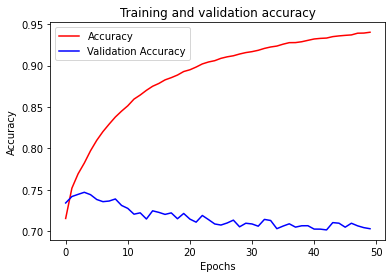

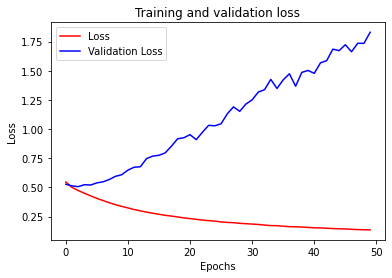

<Figure size 432x288 with 0 Axes>

In [64]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [65]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
                    tf.keras.layers.LSTM(32, activation = 'relu'),
                    tf.keras.layers.Dense(24, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()

training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

num_epochs = 50
history2 = model2.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

print("Training Complete")


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 16, 100)           13793900  
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_18 (Dense)            (None, 24)                792       
                                                                 
 dense_19 (Dense)            (None, 1)                 25        
                                                                 
Total params: 13,811,741
Trainable params: 17,841
Non-trainable params: 13,793,900
_________________________________________________________________
Epoch 1/50
4500/4500 [==============================] - 35s 7ms/step - loss: 0.5380 - accuracy: 0.7262 - val_loss: 0.5088 - val_accuracy: 0.7521
Epoch 2/50
4500/4500 [==

<Figure size 432x288 with 0 Axes>

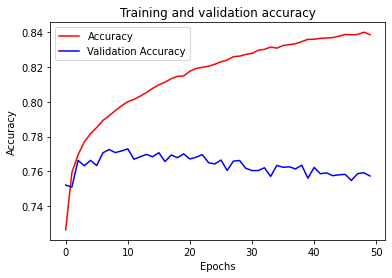

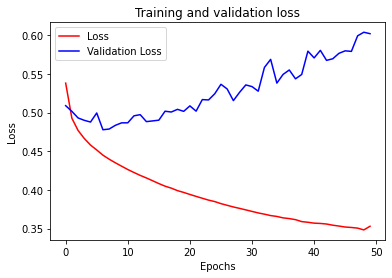

<Figure size 432x288 with 0 Axes>

In [66]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [67]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                    tf.keras.layers.Dense(24, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model3.summary()

training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

num_epochs = 50
history3 = model3.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

print("Training Complete")


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 16, 100)           13793900  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_20 (Dense)            (None, 24)                3096      
                                                                 
 dense_21 (Dense)            (None, 1)                 25        
                                                                 
Total params: 13,881,501
Trainable params: 87,601
Non-trainable params: 13,793,900
_________________________________________________________________
Epoch 1/50
4500/4500 [==============================] - 76s 16ms/step - loss: 0.5339 - accuracy: 0.728

<Figure size 432x288 with 0 Axes>

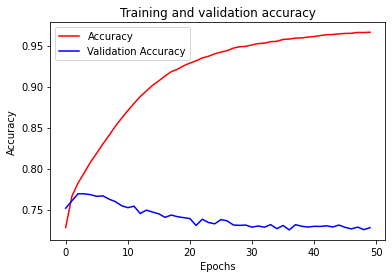

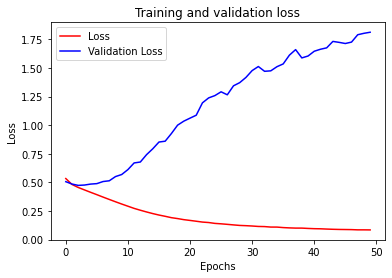

<Figure size 432x288 with 0 Axes>

In [68]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [ ]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                    tf.keras.layers.Dense(24, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model4.summary()

training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

num_epochs = 50
history4 = model4.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

print("Training Complete")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 16, 100)           13793900  
                                                                 
 bidirectional_1 (Bidirectio  (None, 16, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_22 (Dense)            (None, 24)                3096      
                                                                 
 dense_23 (Dense)            (None, 1)                 25        
                                                                 
Total params: 13,980,317
Trainable params: 186,417
No

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history4.history['accuracy']
val_acc=history4.history['val_accuracy']
loss=history4.history['loss']
val_loss=history4.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [ ]:
#  %notebook "C:\Users\jingc\Downloads\Copy of C3_W3_Assignment.ipynb"  # download the notebook to local machine after it finished model fitting